In [1]:
# imports and configuration

# uncomment to use a custom environment file
# from dotenv import load_dotenv
# load_dotenv('../main.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from introdl.utils import get_device, load_results, load_model, summarizer
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, create_image_grid, evaluate_classifier

from viz_functions import visualize_positional_encodings, plot_attention_weights, display_attention

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


In [15]:
class ArithmeticSequenceDataset(Dataset):
    def __init__(self, num_samples, max_length=20, seed=None):
        np.random.seed(seed)
        self.num_samples = num_samples
        self.max_length = max_length
        self.num_map = {
            "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
            "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9
        }
        self.total_positive = 0
        self.correct_dominant_sign = 0
        self.data, self.labels = self.generate_dataset(num_samples, max_length)

    def generate_dataset(self, num_samples, max_length):
        operators = ["plus", "minus"]
        digits = list(self.num_map.keys())  # Including "zero"
        sequences = []
        labels = []
        unique_sequences = set()

        while len(sequences) < num_samples:
            # Generate a random sequence
            length = np.random.randint(1, max_length + 1)
            numbers = np.random.choice(digits, length, replace=True)
            ops = np.random.choice(operators, length, replace=True)
            sequence = " ".join([f"{op} {num}" for op, num in zip(ops, numbers)])
            
            # Ensure uniqueness
            if sequence in unique_sequences:
                continue  # Skip and regenerate if not unique

            unique_sequences.add(sequence)

            # Calculate the sum
            sum_numbers = np.sum([
                self.num_map[num] if op == "plus" else -self.num_map[num] 
                for op, num in zip(ops, numbers)
            ])
            label = int(sum_numbers > 0)  # Return integers 0 or 1
            self.total_positive += label

            # Track dominant sign correctness
            plus_count = sum(ops=="plus")
            minus_count = sum(ops=="minus")
            dominant_sign = 1 if plus_count > minus_count else 0
            if dominant_sign == label:
                self.correct_dominant_sign += 1

            # Store the sequence and label
            sequences.append(sequence)
            labels.append(label)
        
        return sequences, labels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [16]:
num_samples = 20000
dataset = ArithmeticSequenceDataset(num_samples, 10, seed=42)
torch.manual_seed(42)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [17]:
dataset.correct_dominant_sign

16466

In [4]:
vocab = {
    "<PAD>": 0, "<CLS>": 1, "plus": 2, "minus": 3,
    "zero": 4, "one": 5, "two": 6, "three": 7, "four": 8,
    "five": 9, "six": 10, "seven": 11, "eight": 12, "nine": 13
}

# custom collate function
def pad_batch(batch):
    """
    Pads a batch of sequences to the same length and converts them to tensor format.
    Args:
        batch (list of tuples): A list of tuples where each tuple contains a sequence (str) and a label (int).
    Returns:
        tuple: A tuple containing:
            - torch.Tensor: A tensor of padded sequences with shape (batch_size, max_length + 1).
            - torch.Tensor: A tensor of labels with shape (batch_size,).
    Note:
        - Each sequence is tokenized by splitting on whitespace.
        - A special token '<CLS>' is added at the beginning of each sequence.
        - Sequences are padded with the '<PAD>' token to match the length of the longest sequence in the batch.
        - The `vocab` dictionary is used to convert tokens to their corresponding indices.
    """

    sequences, labels = zip(*batch)
    max_length = max(len(seq.split()) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        tokens = ['<CLS>'] + seq.split()
        padded = [vocab[token] for token in tokens] + [vocab["<PAD>"]] * (max_length + 1 - len(tokens))
        padded_sequences.append(padded)
    return torch.tensor(padded_sequences), torch.tensor(labels)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False, collate_fn=pad_batch)

## Single Head Attention Transformer from Scratch

In [5]:
class SingleHeadAttention(nn.Module):
    """
    Implements single-head attention for transformer models.

    Attributes:
        query: Linear layer to project the input into the query space.
        key: Linear layer to project the input into the key space.
        value: Linear layer to project the input into the value space.
        scale: Scaling factor for the attention scores.
        attention_weights: Stores the computed attention weights.
    """

    def __init__(self, embed_dim):
        """
        Initializes the SingleHeadAttention module.

        Args:
            embed_dim (int): Dimensionality of the embedding space.
        """
        super(SingleHeadAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = math.sqrt(embed_dim)
        self.attention_weights = None

    def forward(self, x):
        """
        Forward pass for single-head attention.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).

        Returns:
            torch.Tensor: Output tensor after applying attention.
        """
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.scale + 1e-6)
        self.attention_weights = F.softmax(attention_scores, dim=-1)
        return torch.matmul(self.attention_weights, V)


class TransformerLayer(nn.Module):
    """
    A single transformer layer comprising attention, residual connections,
    layer normalization, and a feedforward network.

    Attributes:
        attention: Single-head attention mechanism.
        norm1: Layer normalization applied after attention.
        mlp: Feedforward network with ReLU activation.
        norm2: Layer normalization applied after the feedforward network.
    """

    def __init__(self, embed_dim, hidden_dim):
        """
        Initializes the TransformerLayer.

        Args:
            embed_dim (int): Dimensionality of the embedding space.
            hidden_dim (int): Dimensionality of the hidden layer in the feedforward network.
        """
        super(TransformerLayer, self).__init__()
        self.attention = SingleHeadAttention(embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        Forward pass for the transformer layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).

        Returns:
            torch.Tensor: Output tensor after applying attention and feedforward network.
        """
        attn_output = self.attention(x)
        x = self.norm1(x + attn_output)
        x2 = self.mlp(x)
        return self.norm2(x + x2)

    def get_attention_weights(self):
        """
        Retrieves attention weights.

        Returns:
            torch.Tensor: Attention weights from the SingleHeadAttention module.
        """
        return self.attention.attention_weights


class PositionalEncoding(nn.Module):
    """
    Adds positional encoding to input embeddings to incorporate positional information.

    Attributes:
        pe: Positional encoding matrix.
    """

    def __init__(self, d_model, max_len=500):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): Dimensionality of the embedding space.
            max_len (int): Maximum length of sequences.
        """
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass for adding positional encoding.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).

        Returns:
            torch.Tensor: Input tensor with positional encoding added.
        """
        return x + self.pe[:, :x.size(1)]


class SingleHeadTransformerEncoder(nn.Module):
    """
    Transformer encoder with single-head attention.

    Attributes:
        embedding: Embedding layer for input tokens.
        pos_encoder: Positional encoding module.
        transformer_layers: Stack of transformer layers.
        classifier: Linear layer for classification using the <CLS> token.
    """

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers):
        """
        Initializes the SingleHeadTransformerEncoder.

        Args:
            vocab_size (int): Vocabulary size.
            embed_dim (int): Dimensionality of the embedding space.
            hidden_dim (int): Dimensionality of the hidden layer in the feedforward network.
            num_classes (int): Number of output classes.
            num_layers (int): Number of transformer layers.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(embed_dim, hidden_dim) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        """
        Forward pass for the transformer encoder.

        Args:
            x (torch.Tensor): Input tensor of token indices.

        Returns:
            torch.Tensor: Output logits for classification.
        """
        x = self.embedding(x)
        x = self.pos_encoder(x)
        for layer in self.transformer_layers:
            x = layer(x)
        cls_token = x[:, 0, :]
        return self.classifier(cls_token)

    def get_attention_weights(self):
        """
        Retrieves attention weights from all transformer layers.

        Returns:
            list: List of attention weight tensors, one for each layer.
        """
        return [layer.get_attention_weights() for layer in self.transformer_layers]

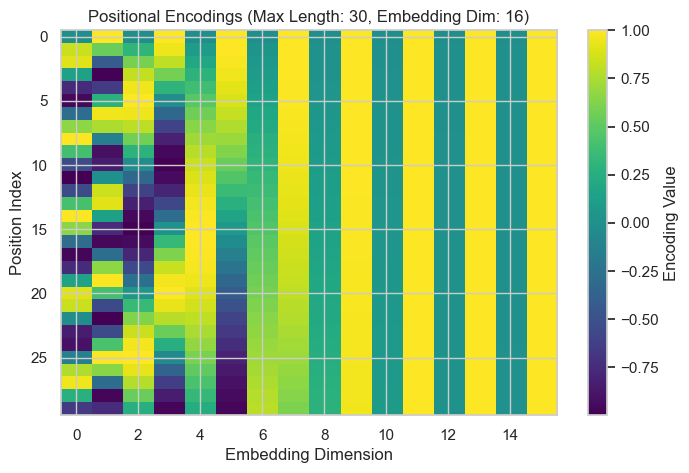

In [6]:

# Create a PositionalEncoding instance and visualize
embed_dim = 16
max_len = 30
pos_encoder = PositionalEncoding(embed_dim, max_len=max_len)
visualize_positional_encodings(pos_encoder, max_len=max_len, d_model=embed_dim)


## Train a Model with a Single Transformer Layer

In [7]:
model = SingleHeadTransformerEncoder(vocab_size=14, embed_dim=16, hidden_dim=64, num_classes=2, num_layers=1)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.003)  # AdamW optimizer, default lr=0.001

device = get_device()
print(device)
model=model.to(device)

ckpt_file = MODELS_PATH / 'L09_math_transformer_one_layer.pt'
epochs = 20

score_funcs = {'ACC':accuracy_score}

cuda


In [9]:
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_metric='ACC',
                        patience=5)

Epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s, train_loss=0.362, val_loss=0.35] 

Early stopping at epoch 7


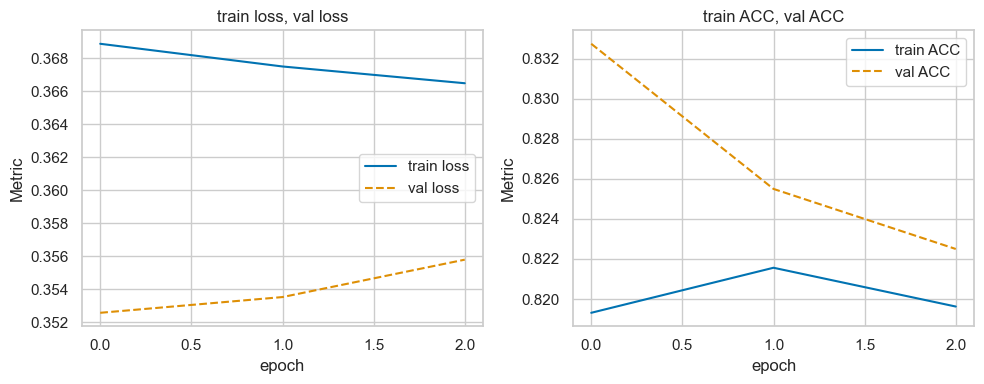

In [10]:
results = load_results(MODELS_PATH / 'L09_math_transformer_one_layer.pt')
plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

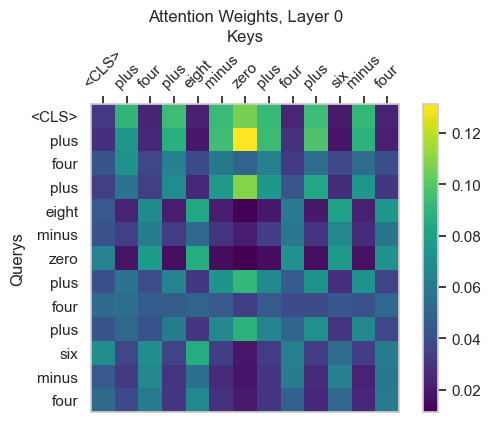

In [11]:
plot_attention_weights(model, valid_loader, vocab, 0, 1, figsize=(6, 4))

In [12]:
display_attention(1, model, valid_loader, vocab)

<IPython.core.display.Javascript object>